In [1]:
# # Pytorch Cuda 오류발생시 해당 코드를 활성화하여
# # 좀더 자세한 오류 원인을 찾자!
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'    # CUDA 커널 호출을 동기화
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # 0번 GPU에서만 연산을 수행하게 강제
# os.environ["TORCH_USE_CUDA_DSA"] = '1'      # CUDA 커널 내부에서 assert 구문 적용

## CFG 모델로 전이학습을 수행하는 코드

In [2]:
import torch

from yolo_dataset import CustomDataset #커스텀 데이터셋 코드
from ModelTrainer import ModelTrainer #train / val 코드
import create_cfg_model as cm # cfg 모델로 Re-training

from yolo_v3_loss import Yolov3Loss, loss_debug
from yolo_v3_metrics import YOLOv3Metrics, metrics_debug #평가지표 코드

from tqdm import tqdm

In [3]:
# CFG모델을 불러와서 Pre-TrainModel 인스턴스화
cfg_file = "yolov3.cfg"
weight_file = "YOLOv3-416.weights"

# CFG 정보 파싱
blocks = cm.parse_cfg(cfg_file)

# CFG 모델 인스턴스화
cfg_model = cm.Yolo_v3_cfg(blocks)
#  pre-trained weights로 CFG 모델 초기화
cm.load_weights(cfg_model, weight_file)

# cfg용 anchorbox리스트
cfg_anchor_box_list = cm.convert_anchor(cfg_file)

In [4]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'

# load_anno=val2014 -> 'instance_val2014.json'참조 + `val2014`img폴더 참조
train_dataset = CustomDataset(root=root_dir, load_anno='val2017', 
                              anchor=cfg_anchor_box_list)
test_dataset = CustomDataset(root=root_dir, load_anno='val2017', 
                             anchor=cfg_anchor_box_list)

print(f"훈련용 : {train_dataset}, \n 검증용 : {test_dataset}")

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
훈련용 : Img 폴더 찾은 *.jpg 개수: 5000, 
 검증용 : Img 폴더 찾은 *.jpg 개수: 5000


In [5]:
from torchvision.transforms import v2

coco_val = [[0.4701, 0.4468, 0.4076], [0.2379, 0.2329, 0.2362]]
# 데이터셋 전처리 방법론 정의
transforamtion = v2.Compose([
    v2.Resize((416, 416)), #이미지 크기를 416, 416로
    v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
    v2.ToDtype(torch.float32, scale=True), #텐서 자료형을 [0~1]로 스케일링
    v2.Normalize(mean=coco_val[0], std=coco_val[1]) #데이터셋 정규화
])

In [6]:
# 데이터셋 전처리 방법론 적용
train_dataset.transform = transforamtion
test_dataset.transform = transforamtion

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
# 전처리가 완료된 데이터셋의 데이터로더 전환
train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# CFG 모델 GPU로 이전
cfg_model.to(device)
print()

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# 손실 함수 설정 (YOLOv3 손실 함수)
# 여기서 cho_mode=True 이면 예측 값을 필터링해서 IOU값으로 Localization Loss연산 수행
# cho_mode=False 이면 기존 방식으로 모든 예측값에 대하여 Localization Loss연산 수행
criterion = Yolov3Loss(device=device.type, cho_mode=True, anchor=cfg_anchor_box_list)
# 옵티마이저는 Pretrain model의 전이학습이기에 매우 작은 learning rate로 설정
optimizer = optim.SGD(cfg_model.parameters(), lr=1e-6, momentum=0.9)
# 스케줄러 설정 (50 에폭 기준 Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

In [10]:
# Train / eval(Val)을 수행하는 클래스 인스턴스화
epoch_step = 1
trainer = ModelTrainer(epoch_step=epoch_step, device=device.type)
metrics = YOLOv3Metrics(anchor=cfg_anchor_box_list, device=device.type)

In [11]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss = []
his_KPI = []
num_epoch = 10

for epoch in range(num_epoch):
    # 훈련 손실과 훈련 성과지표를 반환 받습니다.
    train_loss, train_KPI = trainer.model_train(cfg_model, train_loader, 
                                                criterion, optimizer, scheduler,
                                                metrics, epoch)

    # 검증 손실과 검증 성과지표를 반환 받습니다.
    test_loss, test_KPI = trainer.model_evaluate(cfg_model, test_loader, 
                                                 criterion, metrics, epoch)

    # 손실과 성능지표를 리스트에 저장
    his_loss.append((train_loss, test_loss))
    his_KPI.append((train_KPI, test_KPI))

    # epoch가 특정 배수일 때만 출력하기
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}," + "\t" + 
              f"Training loss: {train_loss:.4f}")
        print(f"Train KPI[ IOU: {train_KPI[0]:.4f}, "+
              f"Precision: {train_KPI[1]:.4f}, "+
              f"Recall: {train_KPI[2]:.4f}, "+ 
              f"Top1_err: {train_KPI[3]:.4f} ]")
        print(f"epoch {epoch+1:03d}," + "\t" + 
              f"Test loss: {test_loss:.4f}")
        print(f"Test KPI[ IOU: {test_KPI[0]:.4f}, "+
              f"Precision: {test_KPI[1]:.4f}, "+
              f"Recall: {test_KPI[2]:.4f}, "+
              f"Top1_err: {test_KPI[3]:.4f} ]")

[훈련중] Loss: 9704.09, KPI: [0.230, 0.016, 0.066, 0.238]: 100%|██████████| 157/157 [02:10<00:00,  1.21it/s] 
100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


epoch 001,	Training loss: 9704.0855
Train KPI[ IOU: 0.2302, Precision: 0.0161, Recall: 0.0659, Top1_err: 0.2377 ]
epoch 001,	Test loss: 7239.9495
Test KPI[ IOU: 0.2257, Precision: 0.0146, Recall: 0.0598, Top1_err: 0.1719 ]


[훈련중] Loss: 6783.25, KPI: [0.225, 0.014, 0.058, 0.163]: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]
100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


epoch 002,	Training loss: 6783.2544
Train KPI[ IOU: 0.2252, Precision: 0.0137, Recall: 0.0580, Top1_err: 0.1633 ]
epoch 002,	Test loss: 6158.1394
Test KPI[ IOU: 0.2248, Precision: 0.0133, Recall: 0.0567, Top1_err: 0.1353 ]


[훈련중] Loss: 5981.32, KPI: [0.225, 0.013, 0.056, 0.135]: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]
100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


epoch 003,	Training loss: 5981.3240
Train KPI[ IOU: 0.2248, Precision: 0.0129, Recall: 0.0559, Top1_err: 0.1352 ]
epoch 003,	Test loss: 5518.0527
Test KPI[ IOU: 0.2248, Precision: 0.0129, Recall: 0.0556, Top1_err: 0.1138 ]


[훈련중] Loss: 5431.83, KPI: [0.224, 0.012, 0.055, 0.115]: 100%|██████████| 157/157 [02:10<00:00,  1.21it/s]
100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


epoch 004,	Training loss: 5431.8320
Train KPI[ IOU: 0.2243, Precision: 0.0122, Recall: 0.0549, Top1_err: 0.1147 ]
epoch 004,	Test loss: 5010.9421
Test KPI[ IOU: 0.2242, Precision: 0.0123, Recall: 0.0546, Top1_err: 0.0970 ]


[훈련중] Loss: 4980.42, KPI: [0.224, 0.012, 0.055, 0.099]: 100%|██████████| 157/157 [02:10<00:00,  1.21it/s]
100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


epoch 005,	Training loss: 4980.4208
Train KPI[ IOU: 0.2244, Precision: 0.0120, Recall: 0.0550, Top1_err: 0.0985 ]
epoch 005,	Test loss: 4583.4879
Test KPI[ IOU: 0.2243, Precision: 0.0124, Recall: 0.0550, Top1_err: 0.0836 ]


[훈련중] Loss: 4572.59, KPI: [0.225, 0.012, 0.055, 0.087]: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]
100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


epoch 006,	Training loss: 4572.5873
Train KPI[ IOU: 0.2245, Precision: 0.0118, Recall: 0.0546, Top1_err: 0.0865 ]
epoch 006,	Test loss: 4181.6753
Test KPI[ IOU: 0.2242, Precision: 0.0120, Recall: 0.0546, Top1_err: 0.0726 ]


[훈련중] Loss: 4211.44, KPI: [0.224, 0.012, 0.055, 0.075]: 100%|██████████| 157/157 [02:10<00:00,  1.21it/s]
100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


epoch 007,	Training loss: 4211.4393
Train KPI[ IOU: 0.2243, Precision: 0.0118, Recall: 0.0546, Top1_err: 0.0748 ]
epoch 007,	Test loss: 3826.2822
Test KPI[ IOU: 0.2245, Precision: 0.0120, Recall: 0.0548, Top1_err: 0.0639 ]


[훈련중] Loss: 3862.99, KPI: [0.225, 0.012, 0.055, 0.066]: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]
100%|██████████| 157/157 [01:40<00:00,  1.55it/s]


epoch 008,	Training loss: 3862.9930
Train KPI[ IOU: 0.2249, Precision: 0.0118, Recall: 0.0548, Top1_err: 0.0663 ]
epoch 008,	Test loss: 3483.0333
Test KPI[ IOU: 0.2246, Precision: 0.0119, Recall: 0.0544, Top1_err: 0.0558 ]


[훈련중] Loss: 3518.49, KPI: [0.225, 0.012, 0.054, 0.058]: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]
100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


epoch 009,	Training loss: 3518.4853
Train KPI[ IOU: 0.2250, Precision: 0.0116, Recall: 0.0545, Top1_err: 0.0581 ]
epoch 009,	Test loss: 3145.5349
Test KPI[ IOU: 0.2253, Precision: 0.0120, Recall: 0.0547, Top1_err: 0.0485 ]


[훈련중] Loss: 3193.44, KPI: [0.226, 0.012, 0.055, 0.052]: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]
100%|██████████| 157/157 [01:41<00:00,  1.55it/s]

epoch 010,	Training loss: 3193.4403
Train KPI[ IOU: 0.2255, Precision: 0.0117, Recall: 0.0546, Top1_err: 0.0515 ]
epoch 010,	Test loss: 2837.0318
Test KPI[ IOU: 0.2257, Precision: 0.0118, Recall: 0.0547, Top1_err: 0.0430 ]


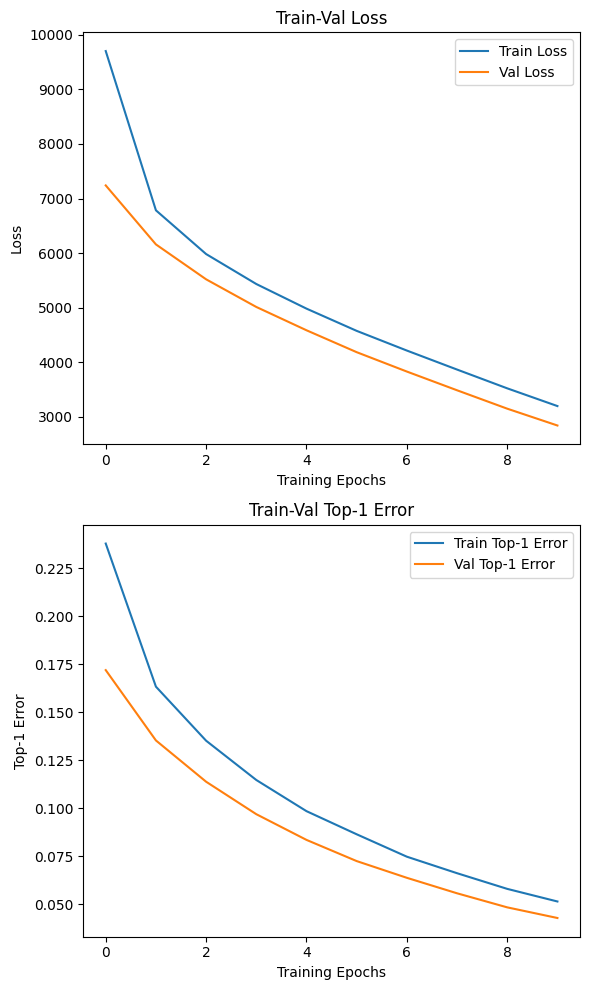

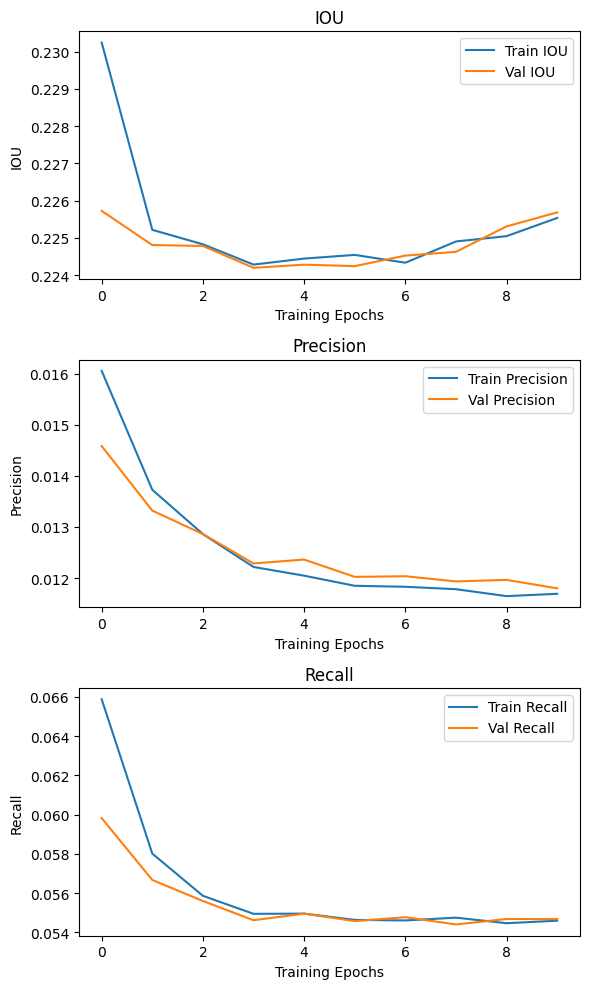

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#histroy는 [train, test] 순임
#KPI는 [iou, precision, recall, top1_error] 순임
np_his_loss = np.array(his_loss)
np_his_KPI = np.array(his_KPI)

# his_loss에서 손실 데이터 추출
train_loss, val_loss = np_his_loss[..., 0], np_his_loss[..., 1]

# his_KPI에서 각 성능 지표 추출
train_iou, val_iou = np_his_KPI[..., 0, 0], np_his_KPI[..., 1, 0]
train_precision, val_precision = np_his_KPI[..., 0, 1], np_his_KPI[..., 1, 1]
train_recall, val_recall = np_his_KPI[..., 0, 2], np_his_KPI[..., 1, 2]
train_top1_errors, val_top1_errors = np_his_KPI[..., 0, 3], np_his_KPI[..., 1, 3]


# 1x2 로 그래프 그리기
plt.figure(figsize=(6, 10))

# Train-Val Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# Train-Val Top-1 Error
plt.subplot(2, 1, 2)
plt.plot(train_top1_errors, label='Train Top-1 Error')
plt.plot(val_top1_errors, label='Val Top-1 Error')
plt.xlabel('Training Epochs')
plt.ylabel('Top-1 Error')
plt.legend()
plt.title('Train-Val Top-1 Error')

plt.tight_layout()
plt.show()

# 1x3로 그래프 그리기
plt.figure(figsize=(6, 10))

# IOU
plt.subplot(3, 1, 1)
plt.plot(train_iou, label='Train IOU')
plt.plot(val_iou, label='Val IOU')
plt.xlabel('Training Epochs')
plt.ylabel('IOU')
plt.legend()
plt.title('IOU')

# Precision
plt.subplot(3, 1, 2)
plt.plot(train_precision, label='Train Precision')
plt.plot(val_precision, label='Val Precision')
plt.xlabel('Training Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

# Recall
plt.subplot(3, 1, 3)
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Val Recall')
plt.xlabel('Training Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()

In [13]:
torch.cuda.empty_cache()